下面有三个版本的cpu神经网络识别MNIST数据集

初始版本使用普通神经网络

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 定义网络结构
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)#第一层64
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, 10)#最后一层对应十个数字

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))#
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.log_softmax(self.fc4(x), dim=1)
        return x

# 获取数据加载器
def get_data_loader(is_train):
    to_tensor = transforms.Compose([transforms.ToTensor()])
    data_set = datasets.MNIST("", train=is_train, transform=to_tensor, download=True)
    return DataLoader(data_set, batch_size=15, shuffle=True)

# 评估模型
def evaluate(test_data, net):
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        for (x, y) in test_data:
            outputs = net.forward(x.view(-1, 28*28))  # 展平图像输入
            for i, output in enumerate(outputs):
                if torch.argmax(output) == y[i]:
                    n_correct += 1
                n_total += 1
    return n_correct / n_total

# 训练和评估模型
def main():
    train_data = get_data_loader(is_train=True)
    test_data = get_data_loader(is_train=False)
    net = Net()  # 实例化模型

    print("initial accuracy:", evaluate(test_data, net))

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(2):  # 训练 2 个 epoch
        for (x, y) in train_data:
            net.zero_grad()
            output = net.forward(x.view(-1, 28*28))  # 展平图像输入
            loss = torch.nn.functional.nll_loss(output, y)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新模型

        print("epoch", epoch, "accuracy:", evaluate(test_data, net))  # 输出每个 epoch 的准确度

    # 可视化结果
    for (n, (x, _)) in enumerate(test_data):
        if n > 3:  # 显示前 4 个图像
            break
        
        predict = torch.argmax(net.forward(x[0].view(-1, 28*28)))  # 获取模型预测结果
        plt.figure(n)  # 创建新的图像窗口
        plt.imshow(x[0].view(28, 28), cmap='gray')  # 显示图像
        plt.title("prediction: " + str(int(predict)))  # 显示预测标签
        plt.show()  # 显示图像

# 开始程序
if __name__ == "__main__":
    main()

下面改成了卷积神经网络

Initial Acc: 0.0992
Epoch  0 | Acc: 0.9676 | Time: 24.31s
Epoch  1 | Acc: 0.9752 | Time: 24.37s
Epoch  2 | Acc: 0.9800 | Time: 24.33s
Epoch  3 | Acc: 0.9824 | Time: 26.56s
Epoch  4 | Acc: 0.9845 | Time: 27.16s
Epoch  5 | Acc: 0.9856 | Time: 27.13s
Epoch  6 | Acc: 0.9854 | Time: 27.33s
Epoch  7 | Acc: 0.9867 | Time: 27.27s
Epoch  8 | Acc: 0.9870 | Time: 27.16s
Epoch  9 | Acc: 0.9888 | Time: 26.70s


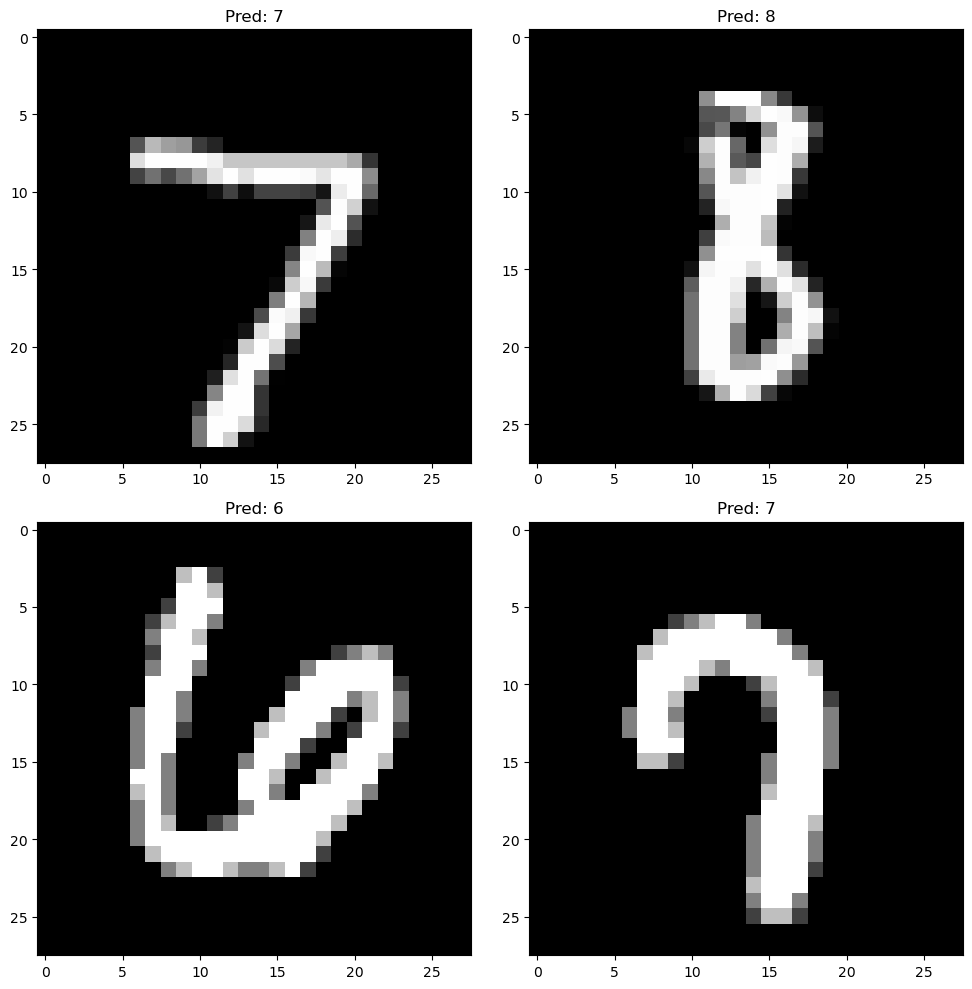

In [20]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1600, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # 输入重塑
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # 正确位置
        x = self.fc2(x)
        return x

def get_data_loader(is_train):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    if is_train:
        transform.transforms.insert(0, transforms.RandomRotation(10))
    return DataLoader(
        datasets.MNIST("", train=is_train, transform=transform, download=True),
        batch_size=256,
        shuffle=True if is_train else False,
        num_workers=0
    )

def evaluate(test_data, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_data:
            outputs = net(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct / total

def main():
    # 数据加载
    train_data = get_data_loader(is_train=True)
    test_data = get_data_loader(is_train=False)
    
    # 模型初始化
    net = Net()
    initial_acc = evaluate(test_data, net)
    print(f"Initial Acc: {initial_acc:.4f}")  # 初始准确率应接近0.1（随机猜测）
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)

    # 训练循环
    for epoch in range(10):
        epoch_start = time.time()
        net.train()
        
        for x, y in train_data:
            optimizer.zero_grad()
            output = net(x)
            loss = torch.nn.functional.cross_entropy(output, y)
            loss.backward()
            optimizer.step()

        acc = evaluate(test_data, net)
        epoch_time = time.time() - epoch_start
        scheduler.step(acc)
        print(f"Epoch {epoch:2d} | Acc: {acc:.4f} | Time: {epoch_time:.2f}s")

    # 可视化（2x2布局）
    plt.figure(figsize=(10, 10))
    test_iter = iter(test_data)
    for i in range(4):
        images, labels = next(test_iter)
        outputs = net(images)
        pred = torch.argmax(outputs, 1)
        
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.title(f"Pred: {pred[i].item()}")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

cpu版本的卷积神经网络

再进行优化

参数量: 0.225226 M
Initial Val Acc: 0.0908
Epoch  0 | Loss: 0.4334 | Val Acc: 0.9708 | Test Acc: 0.9804 | Time: 26.69s
Epoch  1 | Loss: 0.1488 | Val Acc: 0.9728 | Test Acc: 0.9828 | Time: 26.25s
Epoch  2 | Loss: 0.1128 | Val Acc: 0.9814 | Test Acc: 0.9869 | Time: 26.32s
Epoch  3 | Loss: 0.0995 | Val Acc: 0.9810 | Test Acc: 0.9873 | Time: 26.41s
Epoch  4 | Loss: 0.0858 | Val Acc: 0.9836 | Test Acc: 0.9893 | Time: 27.39s
Epoch  5 | Loss: 0.0795 | Val Acc: 0.9852 | Test Acc: 0.9897 | Time: 26.40s
Epoch  6 | Loss: 0.0739 | Val Acc: 0.9838 | Test Acc: 0.9896 | Time: 26.83s
Epoch  7 | Loss: 0.0709 | Val Acc: 0.9862 | Test Acc: 0.9905 | Time: 27.27s
Epoch  8 | Loss: 0.0641 | Val Acc: 0.9848 | Test Acc: 0.9915 | Time: 30.78s
Epoch  9 | Loss: 0.0628 | Val Acc: 0.9888 | Test Acc: 0.9923 | Time: 28.76s
Epoch 10 | Loss: 0.0617 | Val Acc: 0.9866 | Test Acc: 0.9916 | Time: 26.75s
Epoch 11 | Loss: 0.0587 | Val Acc: 0.9868 | Test Acc: 0.9918 | Time: 26.64s
Epoch 12 | Loss: 0.0569 | Val Acc: 0.9886 | Test

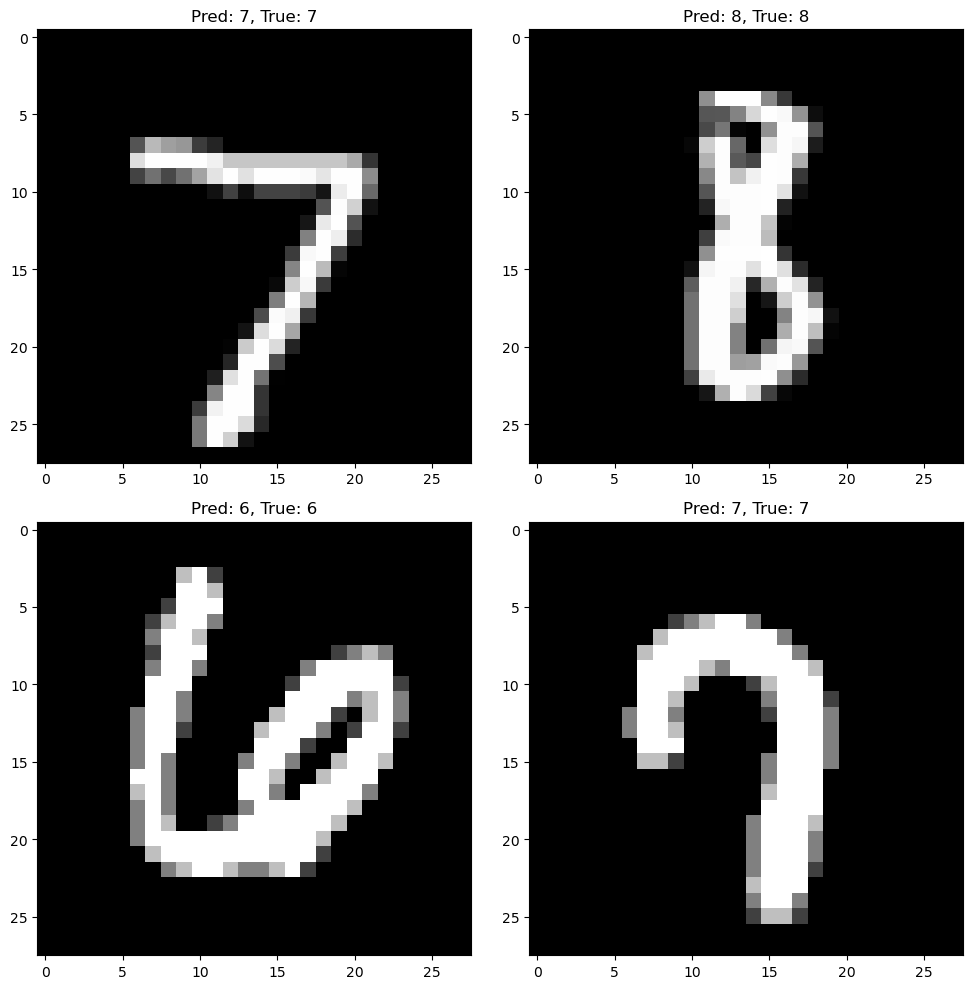

In [25]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import time

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1) # 输入通道1，输出特征图数量32，3x3卷积核捕捉笔画特征（可以调整增大，但是参数会变多），滑动步长1，后续可以考虑分组卷积
        self.bn1 = torch.nn.BatchNorm2d(32)  # 添加BatchNorm批标准化层，加速收敛环节梯度爆炸/消失
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1) # 通道数翻倍
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.dropout = torch.nn.Dropout(0.5)    # 50%概率丢弃神经元，后续考虑丢弃特征图或者空间维度，这里可以防止过拟合
        self.fc1 = torch.nn.Linear(1600, 128)   # 全连接层
        self.fc2 = torch.nn.Linear(128, 10)    # 输出10类
        
        # 参数初始化
        torch.nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')   #Kaiming初始化，适配ReLU
        torch.nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))  # 调整顺序，添加BatchNorm
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def get_data_loaders():
    transform = transforms.Compose([   # 转为Tensor并归一化到[0,1]
        transforms.ToTensor(),  # MNIST专用标准化参数
        transforms.Normalize((0.1307,), (0.3081,))  #MNIST数据集的全局均值0.1307，标准差0.3081,使用数据集统计量实现精准归一化
    ])
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),    # ±10度随机旋转，增加函数泛用性
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    #transforms.RandomAffine(degrees=10, translate=(0.1,0.1))  # 平移+旋转
    #transforms.ColorJitter(contrast=0.2)  # 对比度调整
    #transforms.RandomPerspective()  # 透视变换
    
    full_train = datasets.MNIST("", train=True, transform=train_transform, download=True)
    test_data = datasets.MNIST("", train=False, transform=transform, download=True)
    # 验证集划分
    val_size = 5000
    train_size = len(full_train) - val_size
    train_data, val_data = random_split(full_train, [train_size, val_size])
    
    # 数据加载器配置
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=0)  #这里num_workers=0避免Windows共享内存问题，后续在gpu中可以尝试调整为2，4
    val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)
    
    return train_loader, val_loader, test_loader

def evaluate(data_loader, net):
    net.eval()  # 设置为评估模式（关闭Dropout等）
    correct = 0
    total = 0
    with torch.no_grad(): # 禁用梯度计算。在评估模型时，我们不需要计算梯度，因为不会进行反向传播。使用 torch.no_grad() 可以节省内存并提高计算效率。
        for x, y in data_loader:
            outputs = net(x)
            _, predicted = torch.max(outputs.data, 1)  # 取概率最高类别
            total += y.size(0)
            correct += (predicted == y).sum().item()
    net.train()  # 恢复为训练模式
    return correct / total

def main():
    # 加载数据
    train_loader, val_loader, test_loader = get_data_loaders()
    
    # 初始化模型
    net = Net()
    print("参数量:", sum(p.numel() for p in net.parameters())/1e6, "M")
    
    # 初始评估
    initial_val_acc = evaluate(val_loader, net)
    print(f"Initial Val Acc: {initial_val_acc:.4f}")
     # 优化器配置
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)   #lr=0.001初始学习率。1e-4是L2正则化，防止全连接层过拟合
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)    # 基于验证准确率调整学习率，连续2个epoch无提升则降低LR
    
    best_acc = 0.0
    for epoch in range(30):  # epoch可以调整，实际上用不到这么多轮，只是想看看效果，也可以加入早停机制防止过拟合
        epoch_start = time.time()
        net.train()
        total_loss = 0.0
        
        for x, y in train_loader:
            optimizer.zero_grad()
            output = net(x)
            loss = torch.nn.functional.cross_entropy(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        # 评估与记录
        avg_loss = total_loss / len(train_loader.dataset)
        val_acc = evaluate(val_loader, net)
        test_acc = evaluate(test_loader, net)  # 可选：最终测试时使用
        
        # 更新学习率
        scheduler.step(val_acc)
        
        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(net.state_dict(), "best_model.pth")
         # 进度输出
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch:2d} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f} | Time: {epoch_time:.2f}s")
    
    # 加载最佳模型进行最终测试
    net.load_state_dict(torch.load("best_model.pth"))
    final_test_acc = evaluate(test_loader, net)
    print(f"\nFinal Test Acc: {final_test_acc:.4f}")
    
    # 可视化
    net.eval()
    plt.figure(figsize=(10, 10))
    test_iter = iter(test_loader)
    for i in range(4):
        images, labels = next(test_iter)
        with torch.no_grad():
            outputs = net(images)
        pred = torch.argmax(outputs, 1)
        
        plt.subplot(2, 2, i+1)
        img = images[i].squeeze().numpy()
        img = img * 0.3081 + 0.1307  # 反归一化，逆标准化：original=normalized×σ+μ，还原人眼可识别的图像
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {pred[i].item()}, True: {labels[i].item()}")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()